In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
#import sklearn.metrics.ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('Diabetes.csv')
df.head()

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,pos
1,1,85,66,29,0,26.6,0.351,31,neg
2,8,183,64,0,0,23.3,0.672,32,pos
3,1,89,66,23,94,28.1,0.167,21,neg
4,0,137,40,35,168,43.1,2.288,33,pos


In [3]:
df.corr()

/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_35924/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
pressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
triceps,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
mass,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
pedigree,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


In [4]:
description = df.describe()
rounded_description = description.round(3) 
rounded_description



,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000


In [5]:
columns = df.columns.tolist()
count = (df[columns] == 0).sum()
count

pregnant    111
glucose       5
pressure     35
triceps     227
insulin     374
mass         11
pedigree      0
age           0
diabetes      0
dtype: int64

### Many features have a value of '0' which are impossible, such as triceps, insulin, pressure, etc. These are likely to be NA values which have been listed as '0'. We will fix these values using a few methods.

### Since there are only a few values of glucose, pressure, and mass, we can simply impute the median value of those columns. For triceps and insulin, we need to explore other imputation methods, or drop the columns altogether.

In [6]:
df[['glucose', 'pressure', 'mass']] = df[['glucose', 'pressure', 'mass']].replace(0, np.nan)
for column in ['glucose', 'pressure', 'mass']:
    df[column].fillna(df[column].median(), inplace=True)

df.describe()

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,20.536458,79.799479,32.455208,0.471876,33.240885
std,3.369578,30.438286,12.096642,15.952218,115.244002,6.875177,0.331329,11.760232
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.300000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### can see that mean value for glucose, pressure, and mass increased slightly

### For Insulin and Triceps, we decided to use an IterativeImputer. It is useful only when working with multivariate data, the IterativeImputer in scikit-learn (view documentation) utilizes the data available in other features in order to estimate the missing values being imputed. It does so through an… …"iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned."

### Source link: https://towardsdatascience.com/iterative-imputation-with-scikit-learn-8f3eb22b1a38

In [7]:
iterative_imputer = IterativeImputer()

df.loc[df['triceps'] == 0, 'triceps'] = pd.NA
df.loc[df['insulin'] == 0, 'insulin'] = pd.NA

df[['triceps', 'insulin']] = iterative_imputer.fit_transform(df[['triceps', 'insulin']])
#df[['triceps']] = iterative_imputer.fit_transform(df[['triceps']])

In [8]:
columns = df.columns.tolist()
count = (df[columns] == 0).sum()
count

### remember pregnant can still be 0 since someone may not be pregnant

pregnant    111
glucose       0
pressure      0
triceps       0
insulin       0
mass          0
pedigree      0
age           0
diabetes      0
dtype: int64

In [9]:
description = df.describe()
rounded_description = description.round(3) 
rounded_description


## can see the mean val for insulin and triceps drastically increased

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,121.656,72.387,29.153,155.639,32.455,0.472,33.241
std,3.370,30.438,12.097,8.791,85.479,6.875,0.331,11.760
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000
25%,1.000,99.750,64.000,25.000,120.000,27.500,0.244,24.000
50%,3.000,117.000,72.000,29.153,155.639,32.300,0.372,29.000
75%,6.000,140.250,80.000,32.000,160.291,36.600,0.626,41.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000


In [10]:
label_encoder = LabelEncoder()
df['diabetes'] = label_encoder.fit_transform(df['diabetes'])

### Visualizations after imputation

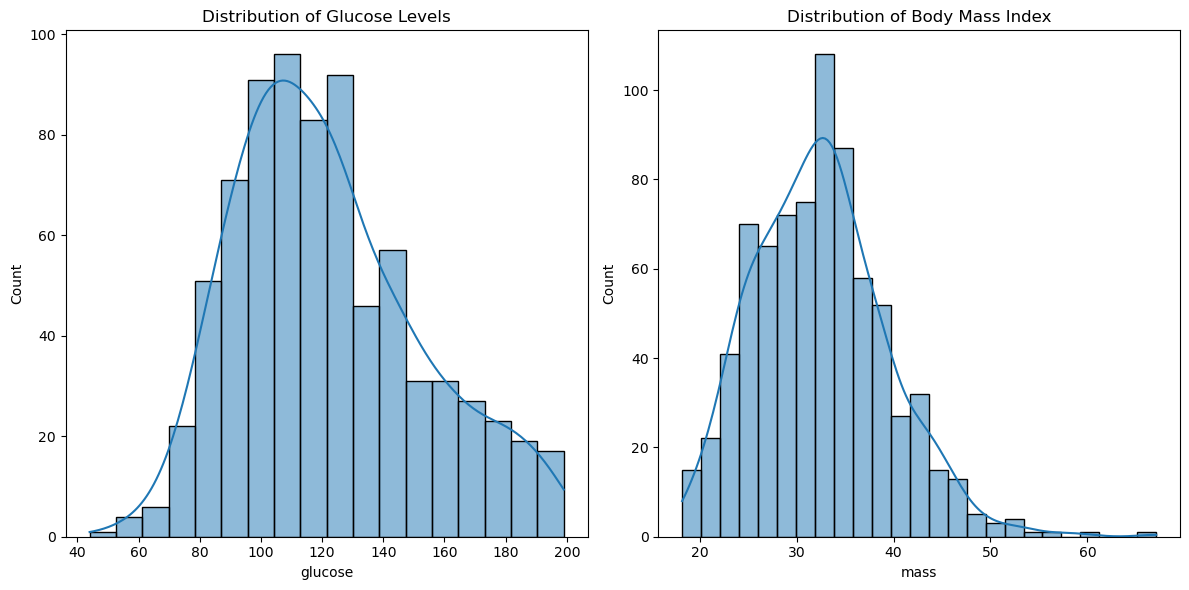

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['glucose'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of Glucose Levels')
sns.histplot(df['mass'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Body Mass Index')
plt.tight_layout()
plt.savefig("histograms.png")  
plt.show()




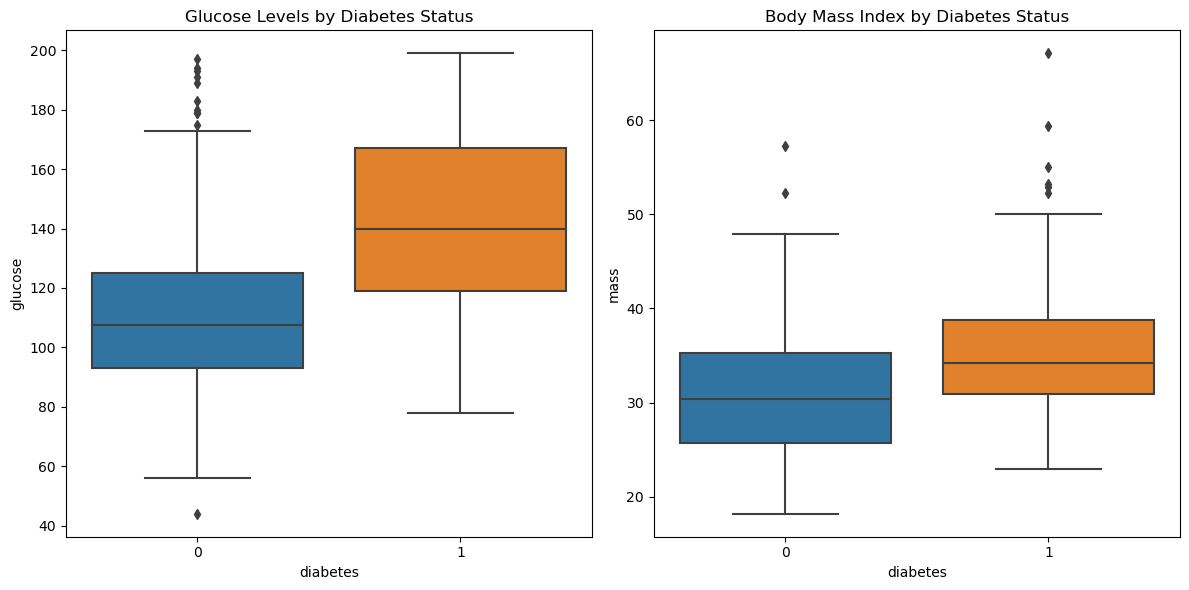

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='diabetes', y='glucose', data=df, ax=ax[0])
ax[0].set_title('Glucose Levels by Diabetes Status')
sns.boxplot(x='diabetes', y='mass', data=df, ax=ax[1])
ax[1].set_title('Body Mass Index by Diabetes Status')
plt.tight_layout()
plt.savefig("boxplots.png") 
plt.show()


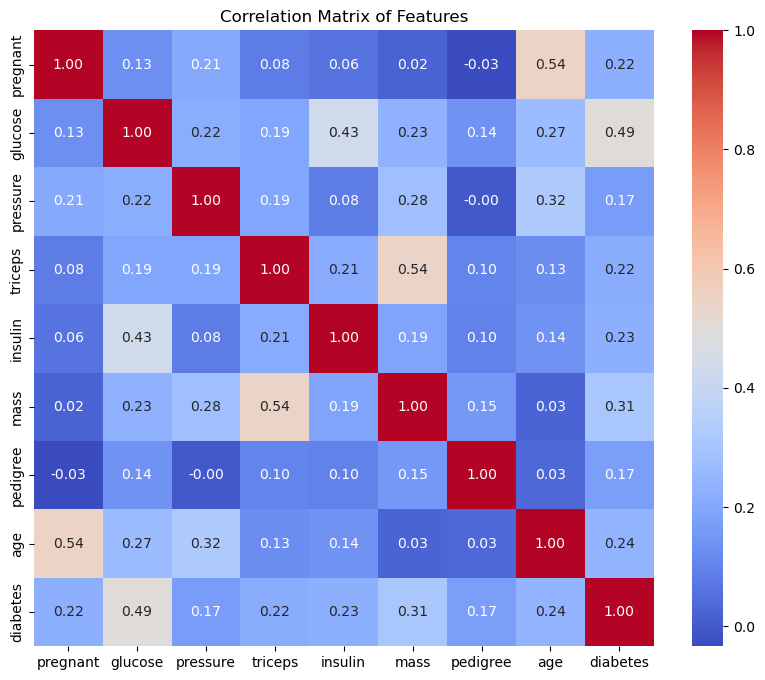

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()


In [14]:
correlation_matrix

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
pregnant,1.000000,0.128213,0.208615,0.082989,0.061116,0.021559,-0.033523,0.544341,0.221898
glucose,0.128213,1.000000,0.218937,0.192925,0.432070,0.231049,0.137327,0.266909,0.492782
pressure,0.208615,0.218937,1.000000,0.192837,0.081345,0.281257,-0.002378,0.324915,0.165723
triceps,0.082989,0.192925,0.192837,1.000000,0.210855,0.542438,0.100966,0.127872,0.215299
insulin,0.061116,0.432070,0.081345,0.210855,1.000000,0.191087,0.098364,0.143432,0.225129
mass,0.021559,0.231049,0.281257,0.542438,0.191087,1.000000,0.153438,0.025597,0.312038
pedigree,-0.033523,0.137327,-0.002378,0.100966,0.098364,0.153438,1.000000,0.033561,0.173844
age,0.544341,0.266909,0.324915,0.127872,0.143432,0.025597,0.033561,1.000000,0.238356
diabetes,0.221898,0.492782,0.165723,0.215299,0.225129,0.312038,0.173844,0.238356,1.000000


### Glucose has a moderate positive correlation with Insulin, which is expected as insulin helps to regulate blood glucose levels.

### Age and Pregnancies are strongly positively correlated, suggesting that older women in the dataset have had more pregnancies.

### BMI (Mass) shows positive correlations with features like Insulin Skin Thickness (Triceps), blood pressure, and glucose which makes sense since higher body mass can influence both skinfold thickness and insulin. Can already see that a lower bmi APPEARS to be better for you through correlation (we dont have proof of this tho)

### Suprisngly, pedigree does not seem to have as strong of a correlation with other features as expected.

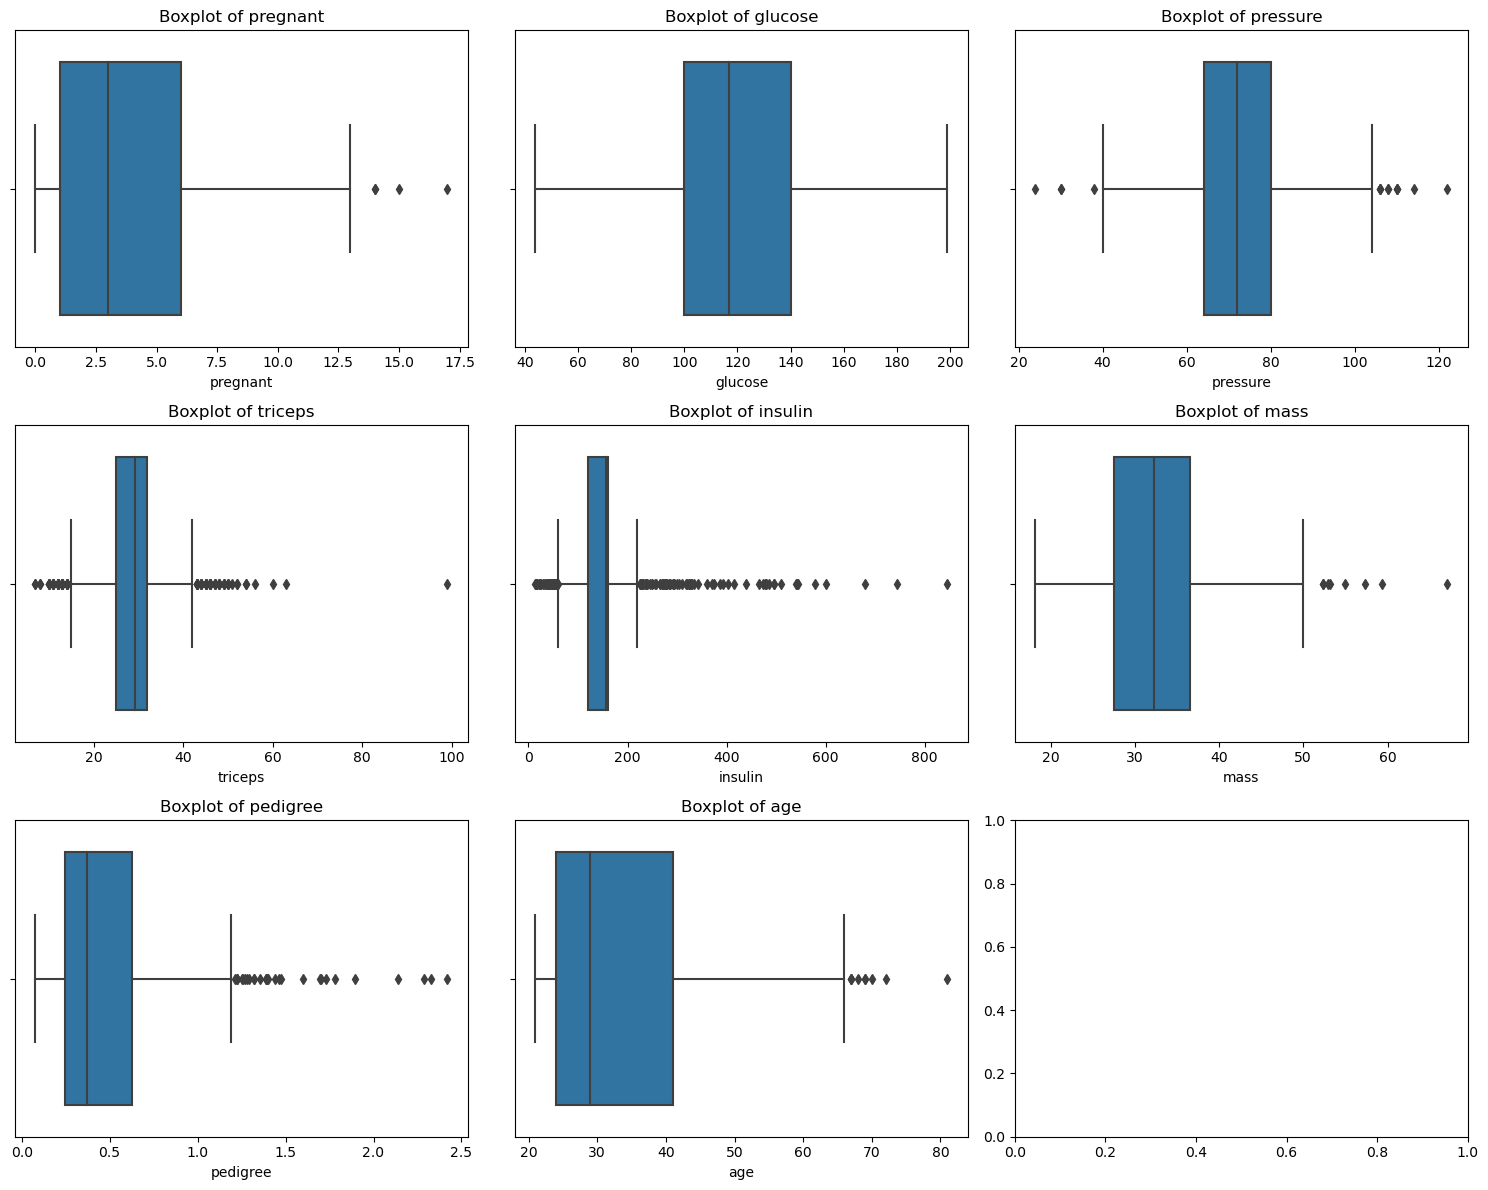

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

for i, col in enumerate(df.columns[:-1]):  
    sns.boxplot(data=df, x=col, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()


### Outliers in several columns based on boxplot. Can potentially drop some outlier rows later to see if it improves performance

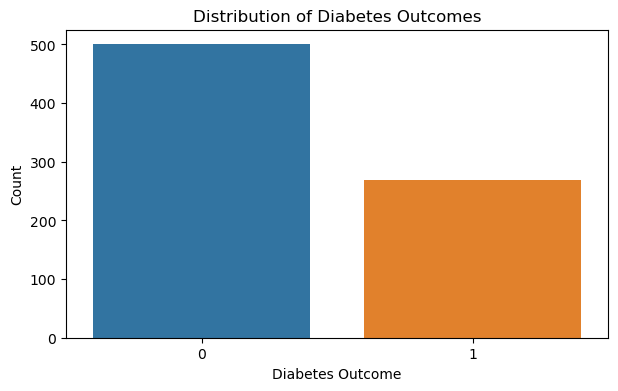

0    0.651042
1    0.348958
Name: diabetes, dtype: float64

In [16]:
plt.figure(figsize=(7, 4))
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Diabetes Outcome')
plt.ylabel('Count')
plt.show()

df['diabetes'].value_counts(normalize=True)


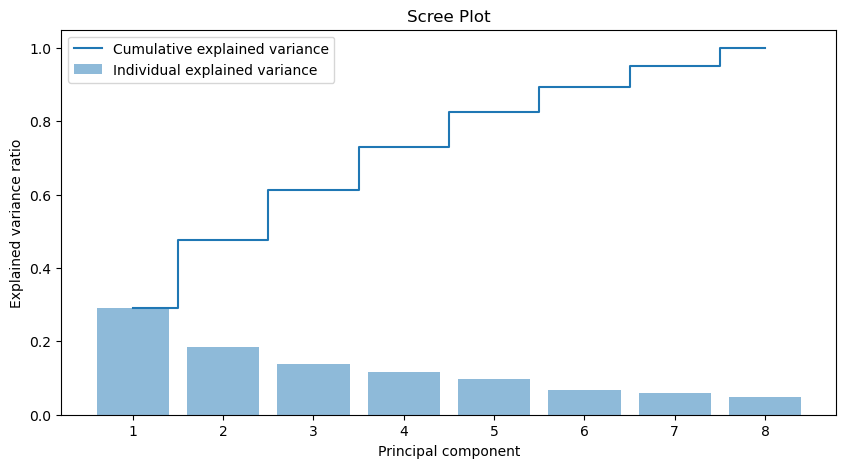

In [17]:
X = df.drop('diabetes', axis = 1)
y = df['diabetes']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.title('Scree Plot')
plt.show()

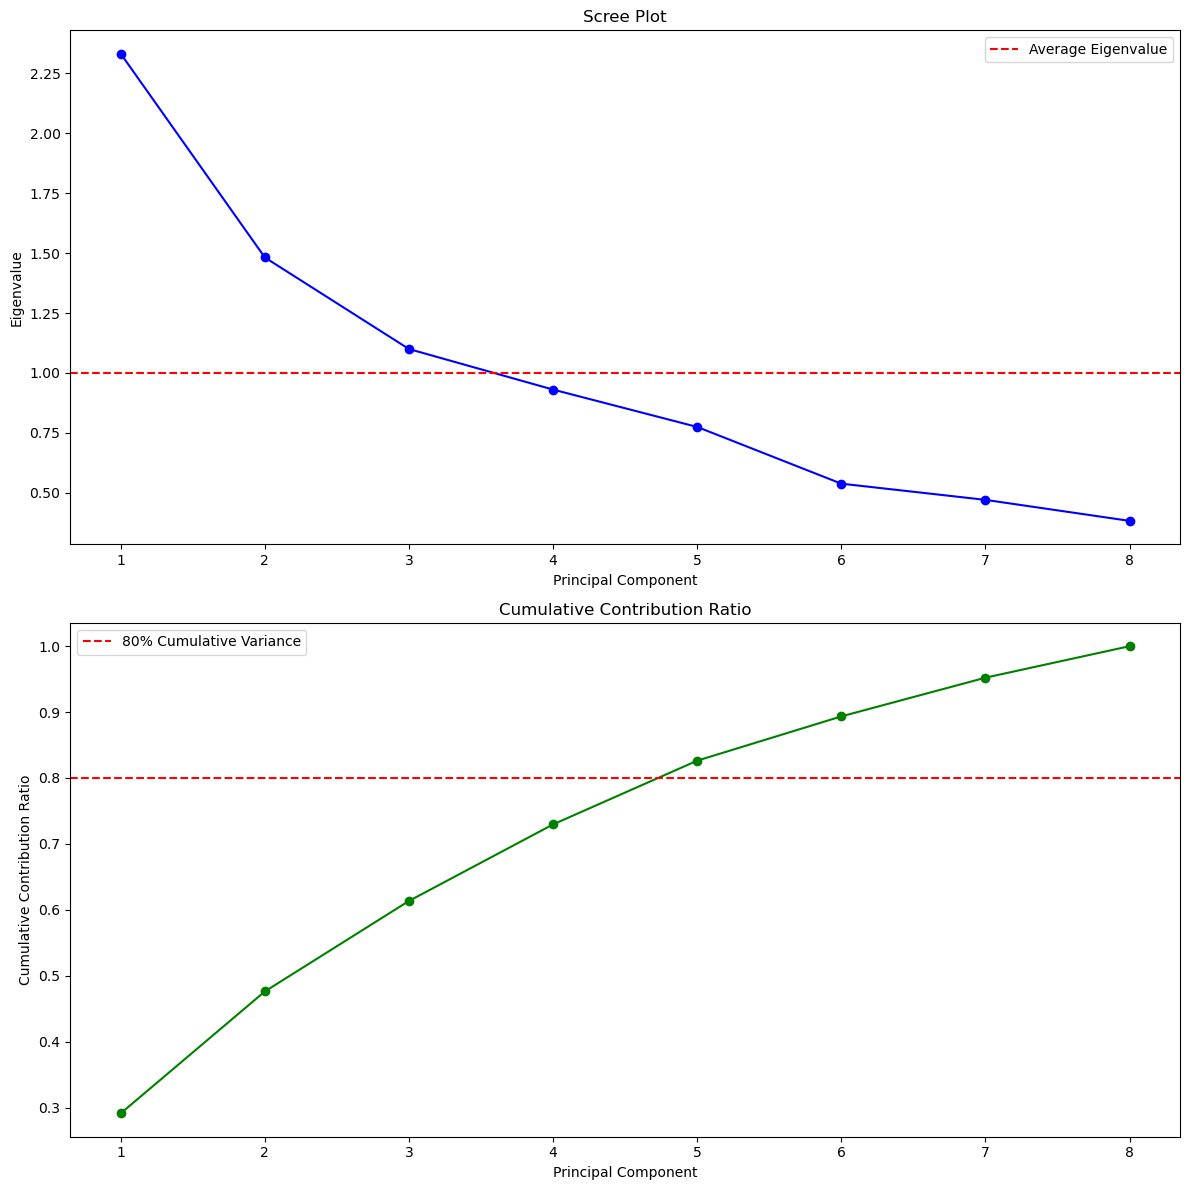

In [18]:
eigenvalues = pca.explained_variance_
contribution_ratios = explained_variance
cumulative_contribution = np.cumsum(contribution_ratios)

average_eigenvalue = np.mean(eigenvalues)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='blue')
ax1.axhline(y=average_eigenvalue, color='red', linestyle='--', label='Average Eigenvalue')
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue')
ax1.legend()

ax2.plot(range(1, len(cumulative_contribution) + 1), cumulative_contribution, marker='o', linestyle='-', color='green')
ax2.axhline(y=0.8, color='red', linestyle='--', label='80% Cumulative Variance')
ax2.set_title('Cumulative Contribution Ratio')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Contribution Ratio')
ax2.legend()

plt.tight_layout()
plt.show()

ax1.figure.savefig('demo-file.pdf')



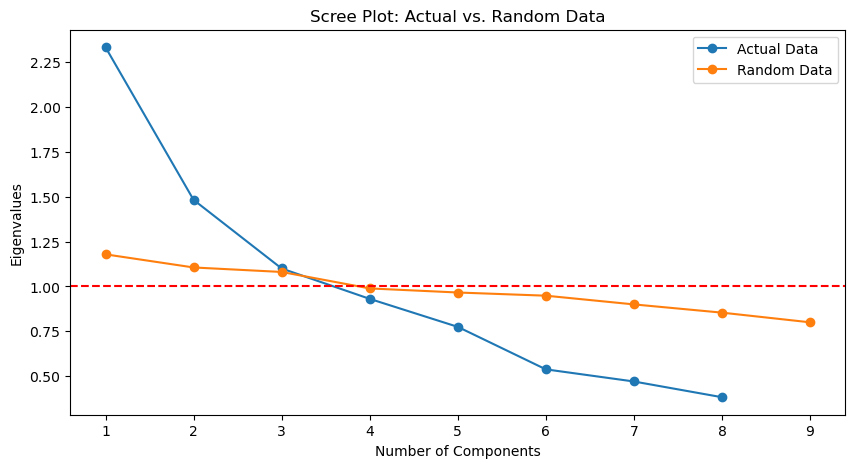

In [19]:
np.random.seed(0)
random_data = np.random.normal(size=df.shape)
pca_random = PCA().fit(random_data)

eigenvalues_random = pca_random.explained_variance_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Actual Data')
plt.plot(range(1, len(eigenvalues_random) + 1), eigenvalues_random, 'o-', label='Random Data')
plt.title('Scree Plot: Actual vs. Random Data')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.show()

In [20]:
explained_variance_df = pd.DataFrame({'Explained Variance': explained_variance}, index=[f'PC{i+1}' for i in range(len(explained_variance))])
explained_variance_df

,Explained Variance
PC1,0.291131
PC2,0.184998
PC3,0.137292
PC4,0.116172
PC5,0.096712
PC6,0.067168
PC7,0.058733
PC8,0.047793


In [21]:
cumulative_explained_variance = explained_variance.cumsum()
cumulative_explained_variance_df = pd.DataFrame({'Cumulative Explained Variance': cumulative_explained_variance}, index=[f'PC{i+1}' for i in range(len(explained_variance))])
cumulative_explained_variance_df

,Cumulative Explained Variance
PC1,0.291131
PC2,0.476130
PC3,0.613421
PC4,0.729594
PC5,0.826306
PC6,0.893474
PC7,0.952207
PC8,1.000000


In [22]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(explained_variance))], index=X.columns)

loadings.drop(['PC4', 'PC5', 'PC6', 'PC7', 'PC8'],axis=1,inplace=True)


In [23]:
loadings

,PC1,PC2,PC3
pregnant,0.299152,-0.557890,-0.076809
glucose,0.419495,0.062905,0.464969
pressure,0.370990,-0.154184,-0.343833
triceps,0.395778,0.337370,-0.362340
insulin,0.344122,0.174405,0.550304
mass,0.391498,0.421964,-0.373386
pedigree,0.145564,0.263019,0.291457
age,0.383900,-0.519192,0.034572


In [24]:
len(explained_variance)

8

In [25]:
covariance_pos = df[df['diabetes'] == 1][['glucose', 'mass']].cov()
covariance_neg = df[df['diabetes'] == 0][['glucose', 'mass']].cov()

covariance_pos

,glucose,mass
glucose,874.316214,10.598407
mass,10.598407,43.501977


In [26]:
covariance_neg

,glucose,mass
glucose,610.445768,19.187596
mass,19.187596,42.303680


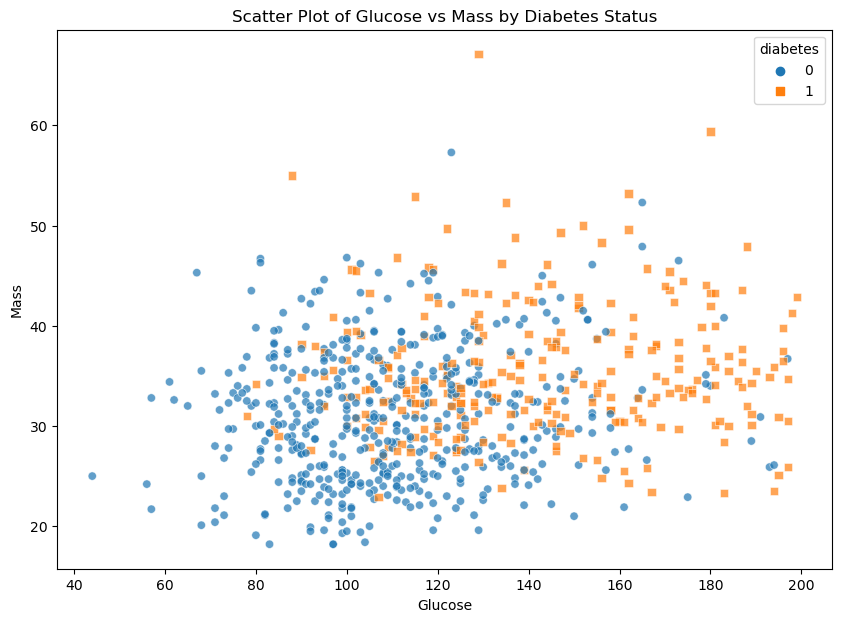

In [27]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='glucose', y='mass', hue='diabetes', style='diabetes', markers=["o", "s"], alpha=0.7)
plt.title('Scatter Plot of Glucose vs Mass by Diabetes Status')
plt.xlabel('Glucose')
plt.ylabel('Mass')
plt.show()


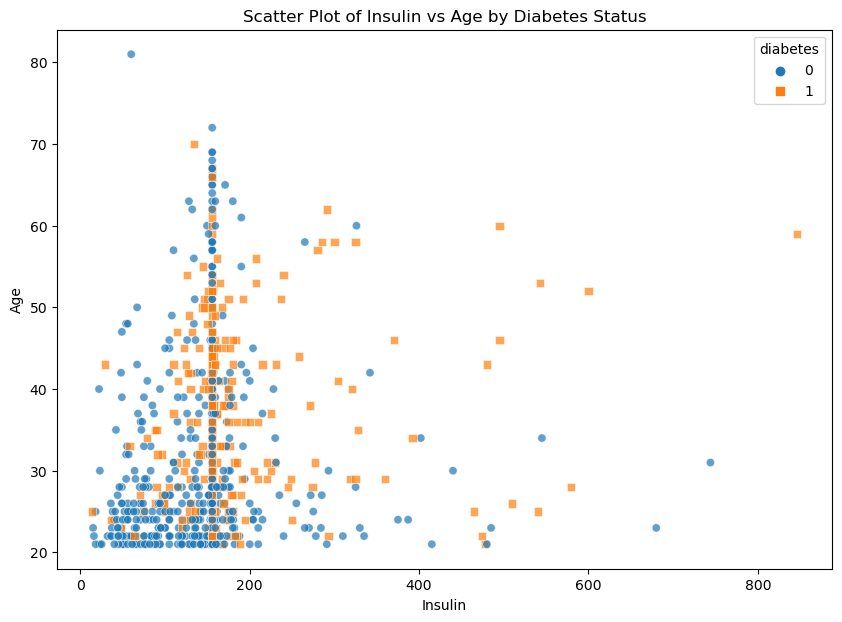

In [28]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='insulin', y='age', hue='diabetes', style='diabetes', markers=["o", "s"], alpha=0.7)
plt.title('Scatter Plot of Insulin vs Age by Diabetes Status')
plt.xlabel('Insulin')
plt.ylabel('Age')
plt.show()


QDA Accuracy: 0.7316017316017316
QDA Cross-validated Average Scores: 0.7356930651048298
QDA Cross-validated Std Scores: 0.014271123497094172


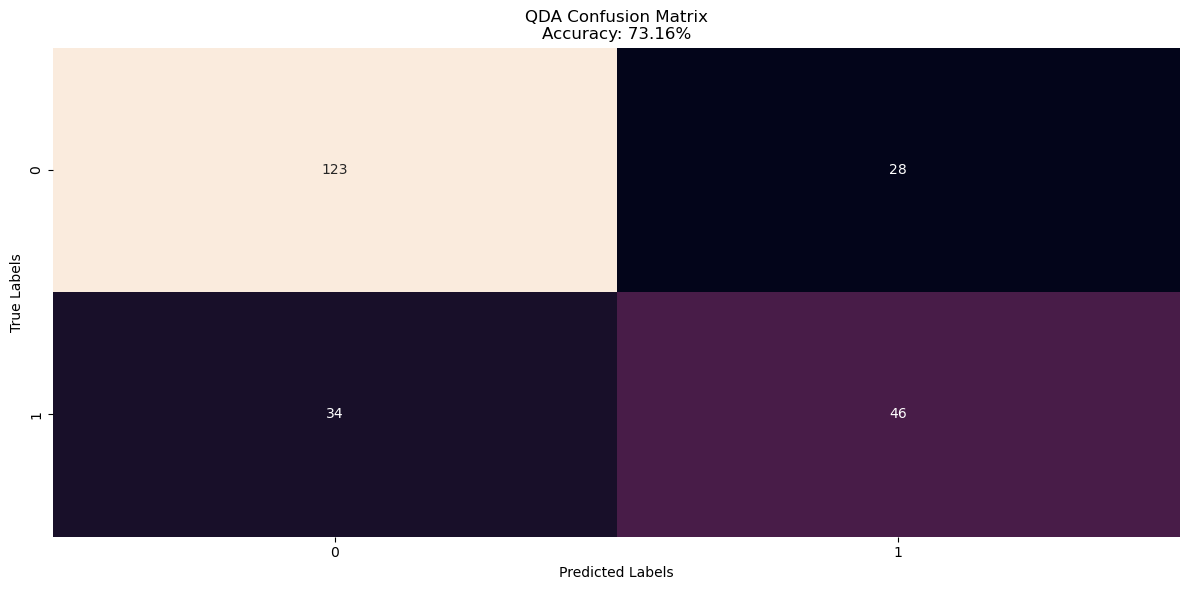

In [32]:
X_pca = X_pca[:, :3]

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
cv_scores_qda = cross_val_score(qda, X_pca, y, cv=StratifiedKFold(5))


qda_conf_matrix = confusion_matrix(y_test, y_pred_qda)
qda_accuracy = accuracy_score(y_test, y_pred_qda)
print(f"QDA Accuracy: {qda_accuracy}")


print(f"QDA Cross-validated Average Scores: {cv_scores_qda.mean()}")
print(f"QDA Cross-validated Std Scores: {cv_scores_qda.std()}")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(qda_conf_matrix, annot=True, fmt="d", cbar=False, ax=ax)
ax.set_title('QDA Confusion Matrix\nAccuracy: {:.2f}%'.format(qda_accuracy * 100))
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

